# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01   42% |█████████████▋                  | 6.2MB 31.9MB/s eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

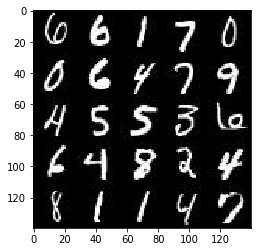

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

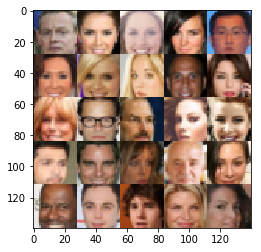

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, shape=(), name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    def conv_layer(tensor_in, filters, strides, use_batch_norm=True):
        tensor_out = tf.layers.conv2d(tensor_in, filters, 5, strides, padding="same",
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        
        if(use_batch_norm):
            tensor_out = tf.layers.batch_normalization(tensor_out, True)

        tensor_out = tf.maximum(alpha * tensor_out, tensor_out)
        
        return tensor_out
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # stack convolutional layers
        x1 = conv_layer(images, 32, 2, False)
        x2 = conv_layer(x1, 64, 1)
        x3 = conv_layer(x2, 128, 2)
        x4 = conv_layer(x3, 256, 1)
        x5 = conv_layer(x4, 512, 2)
        
        # flatten
        flat = tf.reshape(x5, (-1, 4 * 4 * 512))
        
        # compute output
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    def conv_transpose_layer(tensor_in, filters, strides, is_train, use_batch_norm_and_relu=True, padding="same", kernel_size=5):
        tensor_out = tf.layers.conv2d_transpose(tensor_in, filters, kernel_size, strides, padding=padding,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        
        if(use_batch_norm_and_relu):
            tensor_out = tf.layers.batch_normalization(tensor_out, training=is_train)
            tensor_out = tf.maximum(alpha * tensor_out, tensor_out)
        
        return tensor_out
        
    
    with tf.variable_scope("generator", reuse=(not is_train)):
        x1 = tf.layers.dense(z, 4 * 4 * 1024)
        x1 = tf.reshape(x1, (-1, 4, 4, 1024))
        x1 = tf.maximum(alpha * x1, x1) # 4 x 4 x 1024
    
        # stack convolutional layer
        x2 = conv_transpose_layer(x1, 512, 1, is_train, padding="valid", kernel_size = 4) # 7 x 7 x 512
        x3 = conv_transpose_layer(x2, 256, 2, is_train) # 14 x 14 x 256
        x4 = conv_transpose_layer(x3, 128, 1, is_train) # 14 x 14 x 128
        x5 = conv_transpose_layer(x4, 64, 2, is_train) # 28 x 28 x 64   
        logits = conv_transpose_layer(x5, out_channel_dim, 1, is_train, False)
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logit_real = discriminator(input_real)
    d_model_fake, d_logit_fake = discriminator(g_model, True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels=tf.ones_like(d_logit_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.zeros_like(d_logit_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.ones_like(d_logit_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, input_lr = model_inputs(
        data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    
    step_cnt = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step_cnt += 1
                
                # create random noise
                batch_images = 2 * batch_images
                batch_z = np.random.uniform(-1.0, 1.0, size=(batch_size, z_dim))
                
                # run optimizer
                sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                 input_z: batch_z,
                                                 input_lr: learning_rate})
                sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                 input_z: batch_z,
                                                 input_lr: learning_rate})
                
                # print loss every 10 batches
                if(step_cnt % 10 == 0):
                    train_loss_d, train_loss_g = sess.run(
                        [d_loss, g_loss], feed_dict={input_real: batch_images, input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # show generated images every 100 batches
                if(step_cnt % 100 == 0):
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 1.9654... Generator Loss: 0.2185
Epoch 0/2... Discriminator Loss: 1.5404... Generator Loss: 0.3767
Epoch 0/2... Discriminator Loss: 1.2019... Generator Loss: 0.6821
Epoch 0/2... Discriminator Loss: 1.1117... Generator Loss: 1.0357
Epoch 0/2... Discriminator Loss: 1.2377... Generator Loss: 0.7071
Epoch 0/2... Discriminator Loss: 1.2424... Generator Loss: 0.8566
Epoch 0/2... Discriminator Loss: 1.3663... Generator Loss: 0.7180
Epoch 0/2... Discriminator Loss: 1.3888... Generator Loss: 0.7658
Epoch 0/2... Discriminator Loss: 1.4747... Generator Loss: 0.7091
Epoch 0/2... Discriminator Loss: 1.3426... Generator Loss: 0.7488


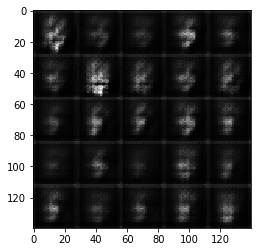

Epoch 0/2... Discriminator Loss: 1.4214... Generator Loss: 0.7266
Epoch 0/2... Discriminator Loss: 1.2551... Generator Loss: 0.8584
Epoch 0/2... Discriminator Loss: 1.3533... Generator Loss: 0.8190
Epoch 0/2... Discriminator Loss: 1.3206... Generator Loss: 0.8205
Epoch 0/2... Discriminator Loss: 1.3231... Generator Loss: 0.7754
Epoch 0/2... Discriminator Loss: 1.2625... Generator Loss: 0.8827
Epoch 0/2... Discriminator Loss: 1.2909... Generator Loss: 0.8899
Epoch 0/2... Discriminator Loss: 1.3217... Generator Loss: 0.8818
Epoch 0/2... Discriminator Loss: 1.4415... Generator Loss: 0.6455
Epoch 0/2... Discriminator Loss: 1.4317... Generator Loss: 0.7979


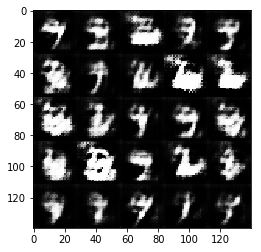

Epoch 0/2... Discriminator Loss: 1.3968... Generator Loss: 0.6371
Epoch 0/2... Discriminator Loss: 1.3643... Generator Loss: 0.8455
Epoch 0/2... Discriminator Loss: 1.3742... Generator Loss: 0.7415
Epoch 0/2... Discriminator Loss: 1.3913... Generator Loss: 0.7933
Epoch 0/2... Discriminator Loss: 1.3983... Generator Loss: 0.7699
Epoch 0/2... Discriminator Loss: 1.3825... Generator Loss: 0.7631
Epoch 0/2... Discriminator Loss: 1.3957... Generator Loss: 0.7685
Epoch 0/2... Discriminator Loss: 1.3901... Generator Loss: 0.6789
Epoch 0/2... Discriminator Loss: 1.3965... Generator Loss: 0.7062
Epoch 0/2... Discriminator Loss: 1.4137... Generator Loss: 0.7974


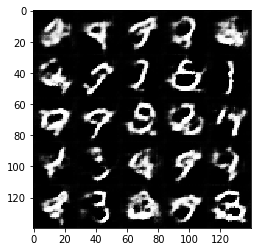

Epoch 0/2... Discriminator Loss: 1.3779... Generator Loss: 0.7794
Epoch 0/2... Discriminator Loss: 1.3929... Generator Loss: 0.7594
Epoch 0/2... Discriminator Loss: 1.3838... Generator Loss: 0.6932
Epoch 0/2... Discriminator Loss: 1.3872... Generator Loss: 0.8070
Epoch 0/2... Discriminator Loss: 1.3965... Generator Loss: 0.8349
Epoch 0/2... Discriminator Loss: 1.3566... Generator Loss: 0.8389
Epoch 0/2... Discriminator Loss: 1.3923... Generator Loss: 0.8311
Epoch 0/2... Discriminator Loss: 1.3864... Generator Loss: 0.8075
Epoch 0/2... Discriminator Loss: 1.3912... Generator Loss: 0.9195
Epoch 0/2... Discriminator Loss: 1.3802... Generator Loss: 0.8106


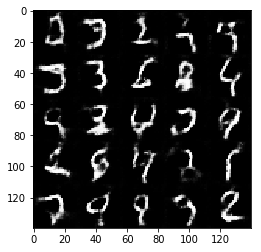

Epoch 0/2... Discriminator Loss: 1.3616... Generator Loss: 0.8112
Epoch 0/2... Discriminator Loss: 1.3968... Generator Loss: 0.6512
Epoch 0/2... Discriminator Loss: 1.3599... Generator Loss: 0.7965
Epoch 0/2... Discriminator Loss: 1.3693... Generator Loss: 0.6927
Epoch 0/2... Discriminator Loss: 1.3833... Generator Loss: 0.6686
Epoch 0/2... Discriminator Loss: 1.3984... Generator Loss: 0.6411
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.8154
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.8059
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.6089
Epoch 1/2... Discriminator Loss: 1.3561... Generator Loss: 0.7798


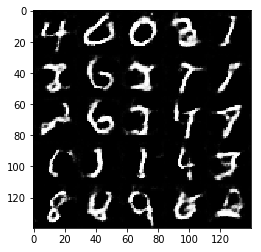

Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.7476
Epoch 1/2... Discriminator Loss: 1.3534... Generator Loss: 0.7107
Epoch 1/2... Discriminator Loss: 1.3488... Generator Loss: 0.8540
Epoch 1/2... Discriminator Loss: 1.3609... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.7950
Epoch 1/2... Discriminator Loss: 1.4579... Generator Loss: 0.5190
Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 0.8200
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 0.8270


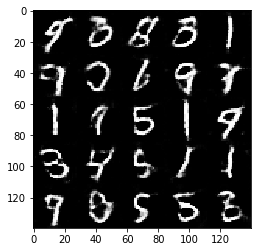

Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 0.7617
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.7628
Epoch 1/2... Discriminator Loss: 1.4215... Generator Loss: 0.5760
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.7850
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.7286
Epoch 1/2... Discriminator Loss: 1.3943... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: 1.3997... Generator Loss: 0.6521
Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 0.8216
Epoch 1/2... Discriminator Loss: 1.4228... Generator Loss: 0.7795


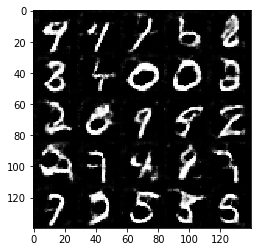

Epoch 1/2... Discriminator Loss: 1.3446... Generator Loss: 0.8393
Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.8100
Epoch 1/2... Discriminator Loss: 1.3410... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 1.3639... Generator Loss: 0.8093
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.8315
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.3516... Generator Loss: 0.7511
Epoch 1/2... Discriminator Loss: 1.3718... Generator Loss: 0.7153
Epoch 1/2... Discriminator Loss: 1.3996... Generator Loss: 0.7836
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.8112


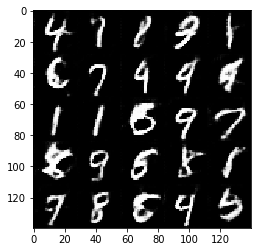

Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 0.8157
Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 0.7457
Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.7977
Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 0.7117
Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 0.7613
Epoch 1/2... Discriminator Loss: 1.3445... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 1.3665... Generator Loss: 0.7765
Epoch 1/2... Discriminator Loss: 1.3636... Generator Loss: 0.7918
Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 0.7693
Epoch 1/2... Discriminator Loss: 1.3410... Generator Loss: 0.7849


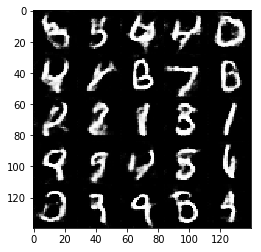

Epoch 1/2... Discriminator Loss: 1.3857... Generator Loss: 0.7736
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.7716
Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.7994


In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.0003
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.1063... Generator Loss: 0.9243
Epoch 0/1... Discriminator Loss: 1.1888... Generator Loss: 1.1233
Epoch 0/1... Discriminator Loss: 1.1603... Generator Loss: 1.2349
Epoch 0/1... Discriminator Loss: 1.5796... Generator Loss: 0.4004
Epoch 0/1... Discriminator Loss: 1.0264... Generator Loss: 1.1129
Epoch 0/1... Discriminator Loss: 0.8959... Generator Loss: 1.3721
Epoch 0/1... Discriminator Loss: 1.2711... Generator Loss: 1.4168
Epoch 0/1... Discriminator Loss: 1.2224... Generator Loss: 0.7783
Epoch 0/1... Discriminator Loss: 1.1667... Generator Loss: 1.0456
Epoch 0/1... Discriminator Loss: 0.9557... Generator Loss: 1.2066


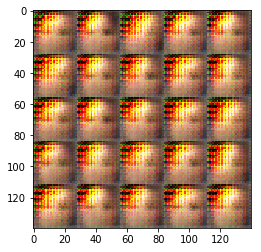

Epoch 0/1... Discriminator Loss: 2.6438... Generator Loss: 0.1154
Epoch 0/1... Discriminator Loss: 1.5649... Generator Loss: 0.4572
Epoch 0/1... Discriminator Loss: 1.4821... Generator Loss: 0.6747
Epoch 0/1... Discriminator Loss: 1.3610... Generator Loss: 0.7444
Epoch 0/1... Discriminator Loss: 1.2920... Generator Loss: 0.7239
Epoch 0/1... Discriminator Loss: 1.3204... Generator Loss: 0.6940
Epoch 0/1... Discriminator Loss: 1.2237... Generator Loss: 0.7585
Epoch 0/1... Discriminator Loss: 1.2254... Generator Loss: 0.7243
Epoch 0/1... Discriminator Loss: 1.2503... Generator Loss: 1.0197
Epoch 0/1... Discriminator Loss: 1.3356... Generator Loss: 0.8016


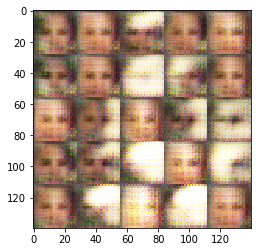

Epoch 0/1... Discriminator Loss: 1.2209... Generator Loss: 0.8530
Epoch 0/1... Discriminator Loss: 1.4927... Generator Loss: 0.7271
Epoch 0/1... Discriminator Loss: 1.3237... Generator Loss: 0.8368
Epoch 0/1... Discriminator Loss: 1.4504... Generator Loss: 0.6845
Epoch 0/1... Discriminator Loss: 1.4199... Generator Loss: 0.8272
Epoch 0/1... Discriminator Loss: 1.3670... Generator Loss: 0.7449
Epoch 0/1... Discriminator Loss: 1.3151... Generator Loss: 0.7863
Epoch 0/1... Discriminator Loss: 1.3647... Generator Loss: 0.6531
Epoch 0/1... Discriminator Loss: 1.3135... Generator Loss: 0.8077
Epoch 0/1... Discriminator Loss: 1.3024... Generator Loss: 0.8875


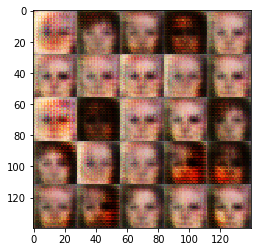

Epoch 0/1... Discriminator Loss: 1.2558... Generator Loss: 0.9992
Epoch 0/1... Discriminator Loss: 1.7099... Generator Loss: 0.4128
Epoch 0/1... Discriminator Loss: 1.3260... Generator Loss: 0.8566
Epoch 0/1... Discriminator Loss: 1.2926... Generator Loss: 0.9178
Epoch 0/1... Discriminator Loss: 1.4195... Generator Loss: 0.7110
Epoch 0/1... Discriminator Loss: 1.3609... Generator Loss: 0.7385
Epoch 0/1... Discriminator Loss: 1.3931... Generator Loss: 0.7345
Epoch 0/1... Discriminator Loss: 1.2891... Generator Loss: 0.9131
Epoch 0/1... Discriminator Loss: 1.2731... Generator Loss: 0.9074
Epoch 0/1... Discriminator Loss: 1.3816... Generator Loss: 1.1301


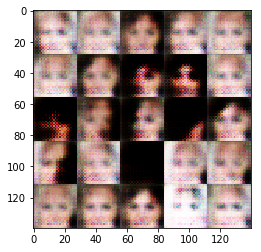

Epoch 0/1... Discriminator Loss: 1.3143... Generator Loss: 0.8681
Epoch 0/1... Discriminator Loss: 1.4011... Generator Loss: 0.8644
Epoch 0/1... Discriminator Loss: 1.3962... Generator Loss: 0.6997
Epoch 0/1... Discriminator Loss: 1.2523... Generator Loss: 0.8987
Epoch 0/1... Discriminator Loss: 1.3526... Generator Loss: 0.9523
Epoch 0/1... Discriminator Loss: 1.2356... Generator Loss: 0.8494
Epoch 0/1... Discriminator Loss: 1.2627... Generator Loss: 1.0011
Epoch 0/1... Discriminator Loss: 1.3107... Generator Loss: 0.8600
Epoch 0/1... Discriminator Loss: 1.2192... Generator Loss: 0.9246
Epoch 0/1... Discriminator Loss: 1.3430... Generator Loss: 0.8593


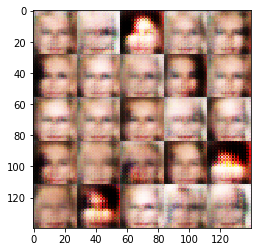

Epoch 0/1... Discriminator Loss: 1.4501... Generator Loss: 0.7572
Epoch 0/1... Discriminator Loss: 1.3946... Generator Loss: 0.8312
Epoch 0/1... Discriminator Loss: 1.2744... Generator Loss: 0.9734
Epoch 0/1... Discriminator Loss: 1.2516... Generator Loss: 1.0169
Epoch 0/1... Discriminator Loss: 1.1268... Generator Loss: 1.0906
Epoch 0/1... Discriminator Loss: 1.3312... Generator Loss: 0.8742
Epoch 0/1... Discriminator Loss: 1.2725... Generator Loss: 0.9108
Epoch 0/1... Discriminator Loss: 1.1046... Generator Loss: 1.1606
Epoch 0/1... Discriminator Loss: 1.3264... Generator Loss: 0.7252
Epoch 0/1... Discriminator Loss: 1.2985... Generator Loss: 0.9309


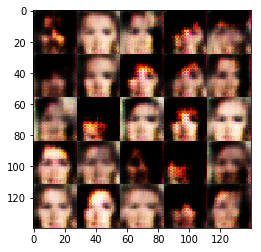

Epoch 0/1... Discriminator Loss: 1.2912... Generator Loss: 0.9158
Epoch 0/1... Discriminator Loss: 1.2525... Generator Loss: 0.9948
Epoch 0/1... Discriminator Loss: 1.2950... Generator Loss: 0.9097
Epoch 0/1... Discriminator Loss: 1.2652... Generator Loss: 0.6787
Epoch 0/1... Discriminator Loss: 1.1172... Generator Loss: 0.8461
Epoch 0/1... Discriminator Loss: 1.0648... Generator Loss: 1.1268
Epoch 0/1... Discriminator Loss: 1.0978... Generator Loss: 1.0445
Epoch 0/1... Discriminator Loss: 1.2144... Generator Loss: 0.9844
Epoch 0/1... Discriminator Loss: 1.4051... Generator Loss: 0.9363
Epoch 0/1... Discriminator Loss: 1.1786... Generator Loss: 1.2283


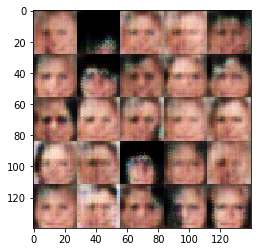

Epoch 0/1... Discriminator Loss: 1.3044... Generator Loss: 1.0169
Epoch 0/1... Discriminator Loss: 1.3232... Generator Loss: 0.9268
Epoch 0/1... Discriminator Loss: 1.1758... Generator Loss: 1.2154
Epoch 0/1... Discriminator Loss: 1.2673... Generator Loss: 0.9139
Epoch 0/1... Discriminator Loss: 1.2944... Generator Loss: 0.7096
Epoch 0/1... Discriminator Loss: 1.3025... Generator Loss: 0.8077
Epoch 0/1... Discriminator Loss: 1.0380... Generator Loss: 1.0873
Epoch 0/1... Discriminator Loss: 1.2385... Generator Loss: 0.9137
Epoch 0/1... Discriminator Loss: 1.3227... Generator Loss: 0.7364
Epoch 0/1... Discriminator Loss: 1.1240... Generator Loss: 0.9839


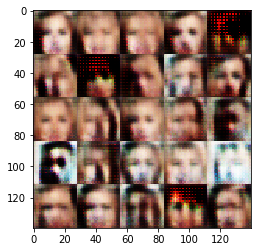

Epoch 0/1... Discriminator Loss: 1.0534... Generator Loss: 1.7341
Epoch 0/1... Discriminator Loss: 1.1487... Generator Loss: 0.9334
Epoch 0/1... Discriminator Loss: 1.2858... Generator Loss: 0.9365
Epoch 0/1... Discriminator Loss: 1.2361... Generator Loss: 1.0273
Epoch 0/1... Discriminator Loss: 1.3976... Generator Loss: 0.6651
Epoch 0/1... Discriminator Loss: 1.3639... Generator Loss: 0.7757
Epoch 0/1... Discriminator Loss: 1.3703... Generator Loss: 1.6513
Epoch 0/1... Discriminator Loss: 1.2166... Generator Loss: 1.0021
Epoch 0/1... Discriminator Loss: 1.3003... Generator Loss: 0.9637
Epoch 0/1... Discriminator Loss: 1.2743... Generator Loss: 0.9253


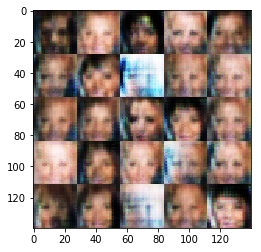

Epoch 0/1... Discriminator Loss: 1.1395... Generator Loss: 1.1204
Epoch 0/1... Discriminator Loss: 0.6418... Generator Loss: 2.2520
Epoch 0/1... Discriminator Loss: 0.9048... Generator Loss: 1.8557
Epoch 0/1... Discriminator Loss: 1.1754... Generator Loss: 1.0059
Epoch 0/1... Discriminator Loss: 1.1025... Generator Loss: 1.2536
Epoch 0/1... Discriminator Loss: 1.1571... Generator Loss: 1.2176
Epoch 0/1... Discriminator Loss: 1.1327... Generator Loss: 1.3600
Epoch 0/1... Discriminator Loss: 1.3318... Generator Loss: 0.7573
Epoch 0/1... Discriminator Loss: 1.2258... Generator Loss: 0.8149
Epoch 0/1... Discriminator Loss: 1.3284... Generator Loss: 1.0193


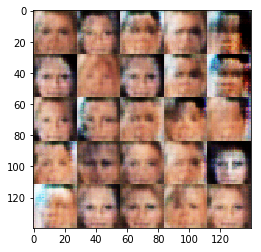

Epoch 0/1... Discriminator Loss: 1.1684... Generator Loss: 1.2495
Epoch 0/1... Discriminator Loss: 1.2428... Generator Loss: 0.7529
Epoch 0/1... Discriminator Loss: 1.3491... Generator Loss: 0.9572
Epoch 0/1... Discriminator Loss: 1.2964... Generator Loss: 0.8667
Epoch 0/1... Discriminator Loss: 1.2418... Generator Loss: 1.3177
Epoch 0/1... Discriminator Loss: 1.3746... Generator Loss: 0.7394
Epoch 0/1... Discriminator Loss: 1.2545... Generator Loss: 0.9947
Epoch 0/1... Discriminator Loss: 0.9570... Generator Loss: 2.1565
Epoch 0/1... Discriminator Loss: 1.2297... Generator Loss: 0.8070
Epoch 0/1... Discriminator Loss: 1.2626... Generator Loss: 0.9271


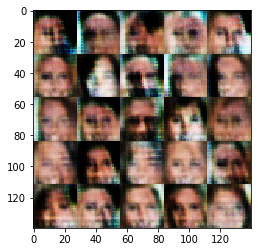

Epoch 0/1... Discriminator Loss: 1.2598... Generator Loss: 0.8758
Epoch 0/1... Discriminator Loss: 1.2635... Generator Loss: 0.9364
Epoch 0/1... Discriminator Loss: 1.2624... Generator Loss: 1.1882
Epoch 0/1... Discriminator Loss: 1.2464... Generator Loss: 0.9314
Epoch 0/1... Discriminator Loss: 1.2844... Generator Loss: 0.9394
Epoch 0/1... Discriminator Loss: 1.3037... Generator Loss: 0.8291
Epoch 0/1... Discriminator Loss: 1.3691... Generator Loss: 0.6909
Epoch 0/1... Discriminator Loss: 1.3224... Generator Loss: 0.9142
Epoch 0/1... Discriminator Loss: 1.3491... Generator Loss: 0.8096
Epoch 0/1... Discriminator Loss: 1.2967... Generator Loss: 0.8167


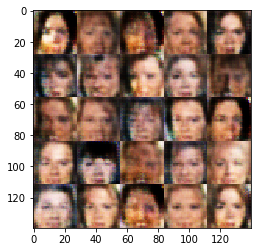

Epoch 0/1... Discriminator Loss: 1.3594... Generator Loss: 1.0544
Epoch 0/1... Discriminator Loss: 1.3560... Generator Loss: 0.8592
Epoch 0/1... Discriminator Loss: 1.3272... Generator Loss: 0.8773
Epoch 0/1... Discriminator Loss: 1.3627... Generator Loss: 0.6822
Epoch 0/1... Discriminator Loss: 1.2214... Generator Loss: 0.9509
Epoch 0/1... Discriminator Loss: 1.3042... Generator Loss: 1.4386
Epoch 0/1... Discriminator Loss: 1.3340... Generator Loss: 0.8236
Epoch 0/1... Discriminator Loss: 1.5216... Generator Loss: 0.7416
Epoch 0/1... Discriminator Loss: 1.2847... Generator Loss: 0.9678
Epoch 0/1... Discriminator Loss: 1.3130... Generator Loss: 0.6951


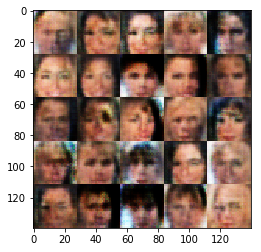

Epoch 0/1... Discriminator Loss: 1.2501... Generator Loss: 0.8330
Epoch 0/1... Discriminator Loss: 1.3119... Generator Loss: 0.6901
Epoch 0/1... Discriminator Loss: 1.3250... Generator Loss: 0.7216
Epoch 0/1... Discriminator Loss: 1.3655... Generator Loss: 0.8678
Epoch 0/1... Discriminator Loss: 1.3312... Generator Loss: 0.7642
Epoch 0/1... Discriminator Loss: 1.2664... Generator Loss: 0.9162
Epoch 0/1... Discriminator Loss: 1.3452... Generator Loss: 0.8464
Epoch 0/1... Discriminator Loss: 1.2367... Generator Loss: 0.9933
Epoch 0/1... Discriminator Loss: 1.3860... Generator Loss: 1.0336
Epoch 0/1... Discriminator Loss: 1.4459... Generator Loss: 0.7659


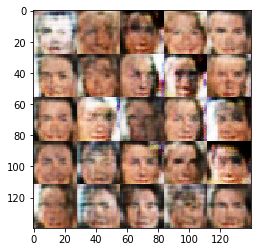

Epoch 0/1... Discriminator Loss: 1.3159... Generator Loss: 0.7998
Epoch 0/1... Discriminator Loss: 1.3320... Generator Loss: 0.8349
Epoch 0/1... Discriminator Loss: 1.2884... Generator Loss: 0.8324
Epoch 0/1... Discriminator Loss: 1.2570... Generator Loss: 0.8353
Epoch 0/1... Discriminator Loss: 1.3005... Generator Loss: 0.8152
Epoch 0/1... Discriminator Loss: 1.3102... Generator Loss: 0.8538
Epoch 0/1... Discriminator Loss: 1.2878... Generator Loss: 0.8354
Epoch 0/1... Discriminator Loss: 1.2564... Generator Loss: 0.7403
Epoch 0/1... Discriminator Loss: 1.3238... Generator Loss: 0.8935
Epoch 0/1... Discriminator Loss: 1.3523... Generator Loss: 0.7670


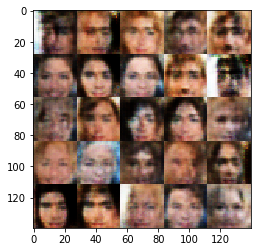

Epoch 0/1... Discriminator Loss: 1.2614... Generator Loss: 0.9351
Epoch 0/1... Discriminator Loss: 1.3705... Generator Loss: 0.7518
Epoch 0/1... Discriminator Loss: 1.3931... Generator Loss: 0.7041
Epoch 0/1... Discriminator Loss: 1.2970... Generator Loss: 1.1056
Epoch 0/1... Discriminator Loss: 1.3232... Generator Loss: 0.8567
Epoch 0/1... Discriminator Loss: 1.3793... Generator Loss: 0.8023
Epoch 0/1... Discriminator Loss: 1.4279... Generator Loss: 0.7889
Epoch 0/1... Discriminator Loss: 1.3985... Generator Loss: 0.7829


In [13]:
batch_size = 128
z_dim = 512
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.